<a href="https://colab.research.google.com/github/arunm917/CS6910-Assignment-2/blob/main/CS6910_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing packages and assigning directory

In [2]:
!pip install wandb -qqq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 62.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 10.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 6.8 MB/s eta 0:00:00


In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.transforms as transforms
import random
from torchvision.datasets import ImageFolder
from tqdm import tqdm
from glob import glob
import torchvision.datasets as datasets
from torch.utils.data import ConcatDataset
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
from torch.nn.modules.pooling import MaxPool2d
import torch.optim as optim
import wandb
# import splitfolders

In [ ]:
# API = 887362a2ceb2116d60b2d826763161b8361e55a1

In [ ]:
# wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
train_path = '/content/drive/Othercomputers/My Computer/Courses/Deep learning 2023/CS6910-Assignment-2/inaturalist_12K/train'
test_path = '/content/drive/Othercomputers/My Computer/Courses/Deep learning 2023/CS6910-Assignment-2/inaturalist_12K/val'

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


# Preprocessing dataset

In [12]:
# Image transforms
train_transforms = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [13]:
test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [14]:
train_data = ImageFolder(train_path, transform=train_transforms)
train_size = int(0.8*len(train_data))
val_size = len(train_data) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_data, [train_size, val_size])
test_dataset = ImageFolder(test_path, transform=test_transforms)

In [15]:
dataset = DataLoader(train_dataset, shuffle=True, num_workers = 2)
dataiter = iter(dataset)
images, labels = next(dataiter)

In [16]:
print(images.shape)
image_dim = images.shape[2]

torch.Size([1, 3, 224, 224])


## Creating val set with equal images from each class

In [17]:
# # Load the dataset
# dataset = ImageFolder(train_dir, transform=train_transforms)

# #Create a dictionary to store the indices of each class
# class_indices = {}
# for i, (image, label) in enumerate(dataset):
#     if label not in class_indices:
#         class_indices[label] = []
#     class_indices[label].append(i)

# # Split each class into training and validation sets
# train_indices = []
# val_indices = []
# for indices in class_indices.values():
#     random.shuffle(indices)
#     split = int(0.8 * len(indices))
#     train_indices += indices[:split]
#     val_indices += indices[split:]

# # Create subsets for the training and validation sets
# train_dataset = Subset(dataset, train_indices)
# val_dataset = Subset(dataset, val_indices)

# # Create data loaders for training and validation
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [18]:
# # Create train and validation data loaders
# test_dataset = ImageFolder(test_path, transform=test_transforms)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [19]:
# test_dataset.size

In [20]:
# dataiter = iter(train_loader)
# images, labels = next(dataiter)

In [21]:
# print(images.shape)
# print(images[20].shape)
# print(labels[20].item())

#Data visualization

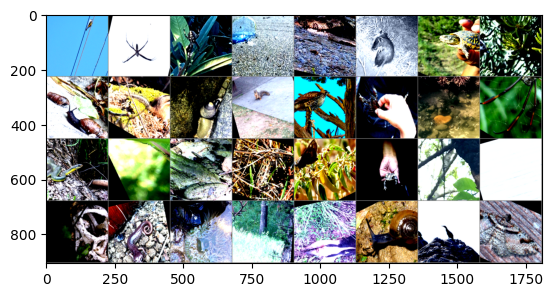

tensor([3, 2, 2, 1, 9, 6, 9, 3, 7, 6, 7, 6, 3, 1, 1, 2, 9, 5, 0, 0, 5, 0, 4, 3,
        4, 0, 1, 6, 6, 7, 3, 5])


In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize the image
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of images from the train loader
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show a few images from the batch
imshow(torchvision.utils.make_grid(images))
print(labels)

# CNN Architecture

In [ ]:
def compute_output_dim(num_filters,num_layers, conv_filter_size, maxpool_filter_size):
    input_size = image_dim
    for i in range (num_layers):
      conv_output_dim = (input_size - conv_filter_size) + 1
      print('conv_output',conv_output_dim)
      maxpool_output_dim = np.floor((conv_output_dim - maxpool_filter_size)/2) + 1
      input_size = maxpool_output_dim
      print('maxpool_output',maxpool_output_dim)
    return int(maxpool_output_dim**2*num_filters)

In [ ]:
compute_output_dim(16,5, 4, 2)

In [31]:
class CNN(nn.Module):
  def __init__(self, architecture, batch_norm, num_layers, num_filters, conv_filter_size, dropout, activation, dense_neurons):
    super(CNN, self).__init__()
    
    self.layers = []
    self.architecture = architecture
    self.batch_norm = batch_norm
    self.num_conv_layers = num_layers
    self.num_filters = num_filters
    self.conv_filter_size = conv_filter_size
    self.dropout = dropout
    self.dense_neurons = dense_neurons
    self.input_filters = 3
    self.maxpool_filter_size = 2

    if activation == 'ReLU':
      self.activation = nn.ReLU
    if activation == 'GELU':
      self.activation = nn.GELU
    if activation == "SiLU":
      self.activation = nn.SiLU
    if activation == "Mish":
      self.activation = nn.Mish
    if activation == 'LeakyReLU':
      self.activation = nn.LeakyReLU
    if activation == 'ELU':
      self.activation = nn.ELU

    if self.batch_norm == 'YES':
      if self.architecture == 'DOUBLE':
        self.num_filters = 8
        for i in range(self.num_conv_layers):
          self.layers.append(nn.Conv2d(self.input_filters,self.num_filters, self.conv_filter_size))
          self.layers.append(nn.BatchNorm2d(self.num_filters))
          self.layers.append(self.activation())
          self.layers.append(nn.MaxPool2d(self.maxpool_filter_size, stride = 2))
          self.layers.append(nn.Dropout(self.dropout))
          self.input_filters = self.num_filters
          self.num_filters = self.num_filters*2
        
      if self.architecture == 'HALF':
        self.num_filters = 128
        for i in range(self.num_conv_layers):
          self.layers.append(nn.Conv2d(self.input_filters,self.num_filters, self.conv_filter_size))
          self.layers.append(nn.BatchNorm2d(self.num_filters))
          self.layers.append(self.activation())
          self.layers.append(nn.MaxPool2d(self.maxpool_filter_size, stride = 2))
          self.layers.append(nn.Dropout(self.dropout))
          self.input_filters = self.num_filters
          self.num_filters = self.num_filters/2
      
      if self.architecture == 'EQUAL':
        for i in range(self.num_conv_layers):
          self.layers.append(nn.Conv2d(self.input_filters,self.num_filters, self.conv_filter_size))
          self.layers.append(nn.BatchNorm2d(self.num_filters))
          self.layers.append(self.activation())
          self.layers.append(nn.MaxPool2d(self.maxpool_filter_size, stride = 2))
          self.layers.append(nn.Dropout(self.dropout))
          self.input_filters = self.num_filters

    if self.batch_norm == 'NO':
      if self.architecture == 'DOUBLE':
        self.num_filters = 8
        for i in range(self.num_conv_layers):
          self.layers.append(nn.Conv2d(self.input_filters,self.num_filters, self.conv_filter_size))
          self.layers.append(self.activation())
          self.layers.append(nn.MaxPool2d(self.maxpool_filter_size, stride = 2))
          self.layers.append(nn.Dropout(self.dropout))
          self.input_filters = self.num_filters
          self.num_filters = self.num_filters*2
        
      if self.architecture == 'HALF':
        self.num_filters = 128
        for i in range(self.num_conv_layers):
          self.layers.append(nn.Conv2d(self.input_filters,self.num_filters, self.conv_filter_size))
          self.layers.append(self.activation())
          self.layers.append(nn.MaxPool2d(self.maxpool_filter_size, stride = 2))
          self.layers.append(nn.Dropout(self.dropout))
          self.input_filters = self.num_filters
          self.num_filters = self.num_filters/2
      
      if self.architecture == 'EQUAL':
        for i in range(self.num_conv_layers):
          self.layers.append(nn.Conv2d(self.input_filters,self.num_filters, self.conv_filter_size))
          self.layers.append(self.activation())
          self.layers.append(nn.MaxPool2d(self.maxpool_filter_size, stride = 2))
          self.layers.append(nn.Dropout(self.dropout))
          self.input_filters = self.num_filters

   # Construct sequential module
    self.cnn_model = nn.Sequential()
    for i, layer in enumerate(self.layers):
      self.cnn_model.add_module(str(i), layer)
  
    output_dim = self.compute_output_dim(self.num_conv_layers, self.conv_filter_size, self.maxpool_filter_size)
    input_dense = (output_dim**2)*self.input_filters

    self.fc_model = nn.Sequential(
        nn.Linear(input_dense, self.dense_neurons),
        self.activation(),
        nn.Linear(self.dense_neurons,10)
    )
  
  def compute_output_dim(self, num_conv_layers, conv_filter_size, maxpool_filter_size):
    input_size = image_dim
    for i in range (num_conv_layers):
      conv_output_dim = (input_size - conv_filter_size) + 1
      # print('conv_output',conv_output_dim)
      maxpool_output_dim = np.floor((conv_output_dim - maxpool_filter_size)/2) + 1
      input_size = maxpool_output_dim
      # print('maxpool_output',maxpool_output_dim)
    return int(maxpool_output_dim)

  def forward(self, x):
    # print(x.shape)
    x = self.cnn_model(x)
    x = x.view(x.size(0), -1)
    # print(x.shape)
    x = self.fc_model(x)
    # print(x.shape)
    return(x)

In [32]:
model = CNN(
    architecture = 'DOUBLE',
    batch_norm = 'YES',
    num_layers = 5,
    num_filters = 32, 
    conv_filter_size = 5,
    dropout = 0.2, 
    activation = 'LeakyReLU',
    dense_neurons = 128).to(device)

In [27]:
def accuracy(dataloader):
  total, correct_predictions = 0, 0
  for data in dataloader:
    X, Y = data
    X, Y = X.to(device), Y.to(device)
    Y_pred = model(X)
    _, pred = torch.max(Y_pred.data, 1)
    total += Y.size(0)
    correct_predictions += (pred == Y).sum().item()
    accuracy = (correct_predictions/total)*100
  return accuracy

In [36]:
# Create data loaders
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers = 2)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False, num_workers = 2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False, num_workers = 2)

In [37]:
#backprop
loss_cr = nn.CrossEntropyLoss()
la = optim.Adam(model.parameters())

In [38]:
loss_batch = []
loss_epoch = []
epochs = 5
for epoch in tqdm(range(epochs)):
  for i, data in enumerate(train_loader, 0):
      images, labels = data
      images, labels = images.to(device), labels.to(device)
      # print(images.size)
      la.zero_grad()
      y_pred = model(images)
      loss = loss_cr(y_pred, labels)
      loss.backward()
      la.step()
      loss_batch.append(loss.item())
  loss_epoch.append(loss.item())
  accuracy_val = accuracy(val_loader)
  accuracy_train = accuracy(train_loader)     
  print('Epoch: %d/%d, Validation acc: %0.2f, Train acc: %0.2f' % (epoch, epochs,accuracy_val, accuracy_train ))
  #wandb.log({'loss_epoch': loss_epoch, 'accuracy_val':accuracy_val, 'accuracy_training':accuracy_training, 'epoch':epoch})
plt.plot(loss_epoch)
plt.show()

  0%|          | 0/5 [05:07<?, ?it/s]


KeyboardInterrupt: ignored

# WANDB

In [ ]:
sweep_configuration = {
  'method': 'grid',
  'name': 'sweep',
  'metric': {'goal': 'maximize', 'name': 'accuracy_val'},
  'parameters': {
      'batch_norm':{'values':['YES','NO']},
      'num_layers': {'values': [5]},
      'num_filters': {'values': [32]},
      'conv_filter_size': {'values': [5]},
      'dropout': {'values': [0.05,0.1,0.2]},
      'activation':{'values':['ReLU', 'GELU', 'LeakyReLU', 'SiLU', 'Mish']},
      'dense_neurons': {'values': [128]},
      'learning_rate': {'values': [1e-4,1e-5,1e-6]},
      'weight_decay': {'values': [0, 0.0005, 0.5]},
      'optimizer': {'values': ['Adam', 'NAdam','RAdam', 'AdamW', 'SGD']},
    } }

In [ ]:
def wandbsweeps():
  wandb.init(project = 'CS6910_Assignment_2')
  print('wandb initialize')
  wandb.run.name = (
        "bn"
        + str(wandb.config.batch_norm)
        + "nf"
        + str(wandb.config.num_filters)
        + "fs"
        + str(wandb.config.conv_filter_size)
        + "do"
        + str(wandb.config.dropout)
        + "lr"
        + str(wandb.config.learning_rate)
        + "opt"
        + wandb.config.optimizer
        + "af"
        + str(wandb.config.activation)
    )
  print('wandb run initialize')
  model = CNN(
    batch_norm = wandb.config.batch_norm,
    num_layers = wandb.config.num_layers,
    num_filters = wandb.config.num_filters, 
    conv_filter_size = wandb.config.conv_filter_size,
    dropout = wandb.config.dropout, 
    activation = wandb.config.activation,
    dense_neurons = wandb.config.dense_neurons).to(device)
  print('model')

  def accuracy(dataloader):
  total, correct_predictions = 0, 0
  for data in dataloader:
    X, Y = data
    X, Y = X.to(device), Y.to(device)
    Y_pred = model(X)
    _, pred = torch.max(Y_pred.data, 1)
    total += Y.size(0)
    correct_predictions += (pred == Y).sum().item()
    accuracy = (correct_predictions/total)*100
  return accuracy
  
  ## Loss and optimizer ##  
  loss_cr = nn.CrossEntropyLoss()
  print('Loss')
  if wandb.config.optimizer == 'Adam':
    la = optim.Adam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)
  elif wandb.config.optimizer == 'NAdam':
    la = optim.NAdam(model.parameters(), lr=wandb.config.learning_rate, weight_decay= wandb.config.weight_decay)
  elif wandb.config.optimizer == 'RAdam':
    la = optim.RAdam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)
  elif wandb.config.optimizer == 'AdamW':
    la = optim.AdamW(model.parameters(), lr=wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)
  elif wandb.config.optimizer == 'SGD':
    la = optim.SGD(model.parameters(), lr=wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)
  else:
      raise ValueError("Invalid optimizer type.")
    
  print('optim')
  loss_batch = []
  loss_epoch = []
  epochs = 5
  for i in tqdm(range(epochs)):
    epoch = i+1
    for j, data in enumerate(train_loader, 0):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        # print(images.size)
        la.zero_grad()
        y_pred = model(images)
        loss = loss_cr(y_pred, labels)
        loss.backward()
        la.step()
        loss_batch.append(loss.item())
    loss_epoch.append(loss.item())
    accuracy_val = accuracy(val_loader)
    accuracy_train = accuracy(train_loader)
    print('training loop')     
    print('Epoch: %d/%d, Validation acc: %0.2f, Train acc: %0.2f' % (epoch, epochs,accuracy_val, accuracy_train ))
    wandb.log({'loss_epoch': loss_epoch, 'accuracy_val':accuracy_val, 'accuracy_training':accuracy_train, 'epoch':epoch})

sweep_id = wandb.sweep(sweep= sweep_configuration, project = 'CS6910_Assignment_2')
wandb.agent(sweep_id, function = wandbsweeps)
# wandb.agent(sweep_id, function = wandbsweeps, count = 10)